In [2]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.2.0
alabaster                          0.7.12
altgraph                           0.17.2
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
apache-beam                        2.40.0
appdirs                            1.4.4
arrow                              1.2.2
asgiref                            3.5.2
asn1crypto                         0.24.0
astor                              0.8.1
astroid                            2.2.5
astropy                            3.2.1
astunparse                         1.6.3
atomicwrites                       1.3.0
attr                               0.3.1
attrs                              19.1.0
Automat                            20.2.0
avro-python3                       1.10.2
aws-lambda-builders                1.18.0
aws-sam-cli                     

# Data Loading Functions


In [105]:
!pip install gdown


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [12]:

!pip install opencv-python matplotlib imageio gdown tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [106]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [107]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [108]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [109]:
import gdown

In [110]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [111]:
def load_video(path:str) -> List[float]: 
    cap = cv2.VideoCapture(path)
    frames = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [112]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [113]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [114]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [115]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [116]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [117]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [118]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [119]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data_female','s34',f'{file_name}.mpg')
    # video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data_female','align',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [120]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [121]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [122]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [123]:
def get_video_dimensions(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file")
        return None

    # Get the dimensions of the video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Release the video capture object
    cap.release()

    return width, height

In [124]:
video_path = '/Users/arnav/Desktop/lipsync/data/s1/bbaf2n.mpg'
dimensions = get_video_dimensions(video_path)
print(dimensions)

(360, 288)


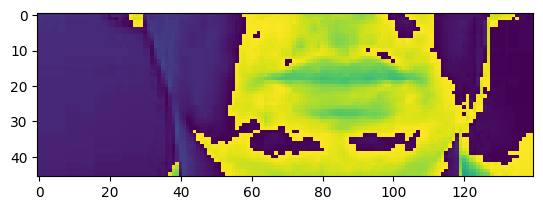

In [125]:
plt.imshow(frames[1])
plt.show()

In [185]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [51]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [186]:
print(''.join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))


bin blue at l six now


In [136]:
!pip install scikit-image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 84.6 kB/s eta 0:00:00 kB/s eta 0:00:01:01


In [141]:
import dlib
from scipy import ndimage
from skimage.transform import resize

class Video(object):
    def __init__(self, vtype='mouth', face_predictor_path=None):
        if vtype == 'face' and face_predictor_path is None:
            raise AttributeError('Face video needs to be accompanied by a face predictor')
        self.face_predictor_path = face_predictor_path
        self.vtype = vtype

    def process_frames_face(self, frames):
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(self.face_predictor_path)
        mouth_frames = self.get_frames_mouth(detector, predictor, frames)
        self.face = np.array(frames)
        self.mouth = np.array(mouth_frames)
        self.set_data(mouth_frames)
        
    def set_data(self, frames):
        data_frames = []
        for frame in frames:
            frame = frame.swapaxes(0, 1)  # swap width and height to form format W x H x C
            if len(frame.shape) < 3:
                frame = np.array([frame]).swapaxes(0, 2).swapaxes(0, 1)  # Add grayscale channel
            data_frames.append(frame)
        frames_n = len(data_frames)
        data_frames = np.array(data_frames)  # T x W x H x C
        # If K is defined and image_data_format is channels_first, roll the axis
        if hasattr(self, 'K') and self.K.image_data_format() == 'channels_first':
            data_frames = np.rollaxis(data_frames, 3)  # C x T x W x H
        self.data = data_frames
        self.length = frames_n

    def get_frames_mouth(self, detector, predictor, frames):
        MOUTH_WIDTH = 100
        MOUTH_HEIGHT = 50
        HORIZONTAL_PAD = 0.19
        normalize_ratio = None
        mouth_frames = []
        for frame in frames:
            dets = detector(frame, 1)
            shape = None
            for k, d in enumerate(dets):
                shape = predictor(frame, d)
                i = -1
            if shape is None:  # Detector doesn't detect face, just return as is
                return frames
            mouth_points = []
            for part in shape.parts():
                i += 1
                if i < 48:  # Only take mouth region
                    continue
                mouth_points.append((part.x, part.y))
            np_mouth_points = np.array(mouth_points)

            mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

            if normalize_ratio is None:
                mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
                mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

                normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

            new_img_shape = (int(frame.shape[0] * normalize_ratio), int(frame.shape[1] * normalize_ratio))
            resized_img = resize(frame, new_img_shape)

            mouth_centroid_norm = mouth_centroid * normalize_ratio

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]

            mouth_frames.append(mouth_crop_image)
        return mouth_frames


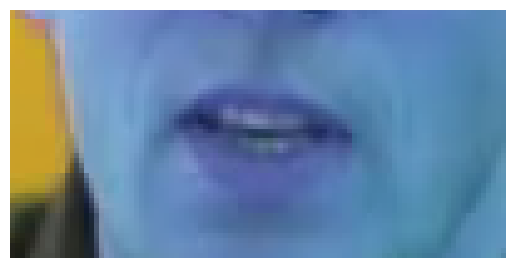

In [144]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

shape_predictor_path = "/Users/arnav/Desktop/lipsync/shape_predictor_68_face_landmarks.dat"


video = Video(vtype='face', face_predictor_path=shape_predictor_path)

video_path = "/Users/arnav/Desktop/lipsync/test_video.mp4"
cap = cv2.VideoCapture(video_path)
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)


video.process_frames_face(frames)


mouth_snippet = video.mouth[0]


plt.imshow(mouth_snippet)
plt.axis('off')
plt.show()


In [53]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [54]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline

In [73]:
from matplotlib import pyplot as plt
import os

In [103]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  2, 39, 14,  9, 14,
        5, 39, 14, 15, 23])>

In [84]:
# data
print(data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>


In [97]:
data.as_numpy_iterator().next()

b'data/s1/srin6p.mpg'

In [98]:
len(frames)

75

In [99]:
sample = data.as_numpy_iterator()

In [100]:
val = sample.next(); val[0]

100

In [102]:
imageio.mimsave('animation.gif', val[0][0], fps=10)

TypeError: 'int' object is not subscriptable

In [41]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue sp at q five soon'>

# Deep Neural Network

In [151]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [152]:
data.as_numpy_iterator().next()[0][0].shape

OpenCV: Couldn't read video stream from file "data/s1/.mpg"
[ERROR:12@27152.458] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): data/s1/.mpg in function 'icvExtractPattern'


2024-02-02 01:55:45.322122: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/var/folders/tl/zv5_pc09609g03x343v11n3r0000gn/T/ipykernel_27786/797274792.py", line 9, in load_data
    alignments = load_alignments(alignment_path)

  File "/var/folders/tl/zv5_pc09609g03x343v11n3r0000gn/T/ipykernel_27786/885867866.py", line 2, in load_alignments
    with open(path, 'r') as f:

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 284, in _modified_open
    return io_open(file, *args, **kwargs)

FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

2024-02-02 01:55:45.373493: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/Users/arnav/miniconda3/envs/mlt/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/var/folders/tl/zv5_pc09609g03x343v11n3r0000gn/T/ipykernel_27786/797274792.py", line 9, in load_data
    alignments = load_alignmen

In [153]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [154]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [155]:
5*17*75

6375

In [156]:
yhat = model.predict(val[0])

IndexError: tuple index out of range

In [48]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp4444gggg'>

In [49]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp4444gggg'>

In [157]:
model.input_shape

(None, 75, 46, 140, 1)

In [158]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train

In [159]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [160]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [161]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [162]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [163]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [164]:
schedule_callback = LearningRateScheduler(scheduler)

In [165]:
example_callback = ProduceExample(test)

In [ ]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 5s 5s/steps - loss: 84.128
Original: set white by v five again
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white with s five soon
Prediction: le e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 18259s 40s/step - loss: 84.1284 - val_loss: 68.5418 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 2s 2s/steps - loss: 70.2446
Original: lay green by s six now
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red by t zero now
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 28643s 64s/step - loss: 70.2446 - val_loss: 64

# Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [175]:
model.load_weights('models_/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [176]:
sample = load_data(tf.convert_to_tensor('/Users/arnav/Desktop/lipsync/data_female/s34/bbac1p.mpg'))

In [177]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at c one please'>]

In [178]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


1/1 [==============================] - 2s 2s/step


In [184]:
decoding_the_words= tf.keras.backend.ctc_decode(), input_length=[75], greedy=True)[0][0].numpy()


2024-02-02 03:54:19.474816: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [180]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoding_the_words]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'plac ble sis s s sene sain be ith o'>]

In [ ]:
print(''.join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))
